In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from Bio.SeqIO import PirIO
import h5py
from time import time
import numpy as np
import sys

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn 
import sklearn.model_selection
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

import pandas as pd


In [16]:
# TODO:
# Play with model architecture 
#    - Attention heads
#    - Hidden Dims
#    - Dropout
#    - Act. Fkt.
#    - Number and dimensoinality of FC layers

# Add second EC prediction

most code from: https://keras.io/examples/nlp/text_classification_with_transformer/

In [2]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output


In [3]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [4]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [5]:
# path to git repo
preamble = "/home/user/Dokumente/#master/Sem_03/ProteinPrediction/ec-number-prediction"

h5py_file = preamble+'/data/ec_vs_NOec_pide100_c50.h5'
fasta_path = preamble+'/data/nonRed_dataset/ec_vs_NOec_pide20_c50_train.fasta'
anno = preamble+'/data/annotations/merged_anno.txt'

print(h5py_file)

print('LOAD - This may take a while, if you run this the first time!')
# https://stackoverflow.com/questions/20928136/input-and-output-numpy-arrays-to-h5py

count = 0

X =  []
y = []

def reduceAnno(anno: str):
    y.append(int(anno[0]))
    return i


with open(anno) as fp:
    with h5py.File(h5py_file, 'r') as h5:
        i = 0
        for line in fp:
            input = line.strip().split('\t')
            if input[0] in h5:

                X.append(np.asarray(h5[input[0][:]]))

                reduceAnno(input[1])

                i += 1

            if i == 200000:
                break

            else:
                pass
                # print(input[0], 'NOT FOUND')

            sys.stdout.write('\r' + str(i))
            
            

/home/user/Dokumente/#master/Sem_03/ProteinPrediction/ec-number-prediction/data/ec_vs_NOec_pide100_c50.h5
LOAD - This may take a while, if you run this the first time!
199999

In [6]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.66)

In [7]:
embed_dim = 1024  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

#inputs = layers.Input(shape=(maxlen,))
#embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
#x = embedding_layer(inputs)

inputs = layers.Input(shape=(embed_dim,))
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(inputs)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(8, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)


In [8]:
X_train_tensor = np.asarray(X_train)
y_train_tensor = np.asarray(y_train)

X_test_tensor = np.asarray(X_test)
y_test_tensor = np.asarray(y_test)


print(len(X_train_tensor), "Training data")
print(len(X_test_tensor), "Test data")

model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train_tensor, y_train_tensor, batch_size=64, epochs=3, validation_data=(X_test_tensor, y_test_tensor)
)


68000 Training data
132000 Test data
Epoch 1/3
1063/1063 [==============================] - 306s 287ms/step - loss: 1.2125 - accuracy: 0.5455 - val_loss: 0.8114 - val_accuracy: 0.7137
Epoch 2/3
1063/1063 [==============================] - 306s 288ms/step - loss: 0.7575 - accuracy: 0.7301 - val_loss: 0.6334 - val_accuracy: 0.7775
Epoch 3/3
1063/1063 [==============================] - 261s 246ms/step - loss: 0.6154 - accuracy: 0.7831 - val_loss: 0.5701 - val_accuracy: 0.7996


Conf-matrix from: https://androidkt.com/keras-confusion-matrix-in-tensorboard/

In [9]:
y_pred=np.argmax(model.predict(X_test_tensor),axis=1)
con_mat = tf.math.confusion_matrix(labels=y_test_tensor, predictions=y_pred).numpy()

In [12]:
classes=[0,1,2,3,4,5,6,7] #too lazy to fix zero classes

In [13]:
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

<ipython-input-13-132f86d5d166>:1: RuntimeWarning: invalid value encountered in true_divide
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)


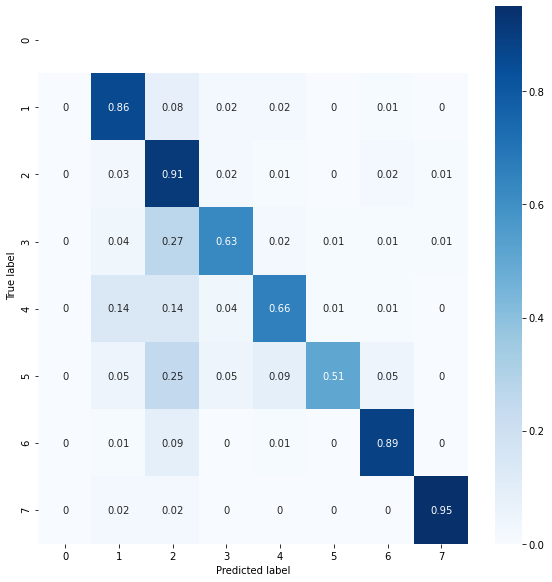

In [14]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [15]:
# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
# Print f1, precision, and recall scores
print('Macro-precision', precision_score(y_test_tensor, y_pred , average="macro"))
print('Macro-recall',recall_score(y_test_tensor, y_pred , average="macro"))
print('Macro-f1',f1_score(y_test_tensor, y_pred , average="macro"))

Macro-precision 0.8261948791409787
Macro-recall 0.7729849765540973
Macro-f1 0.787923382304799
